In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cmocean as cmo
import os,sys,fnmatch,time
import numpy as np
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from salishsea_tools.nc_tools import scDataset
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import ticker

import sys
sys.path.append('/ocean/imachuca/Canyons/analysis_mackenzie_canyon/notebooks/general_circulation/')
import general_functions

%matplotlib inline

http://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/mackenzie_canyon/raw/tip/bathymetry/notebooks/runs_mackenzie04.ipynb

In [2]:
def get_files(dirname, fname, grid):
    files = []    
    for item in os.listdir(dirname):
        if fnmatch.fnmatchcase(item, fname + grid + "*.nc"):
            files += [os.path.join(dirname, item)]
    files.sort(key=os.path.basename)
    return files

In [3]:
def vel_timeseries(dirname, fname, dep_ind):
    
    filesU = get_files(dirname, fname, 'grid_U')        
    filesV = get_files(dirname, fname, 'grid_V')
    filesW = get_files(dirname, fname, 'grid_W')
    print('files')
    
    y,x = slice(1,-1,None), slice(1,-1,None)

    with scDataset(filesU) as dsU, scDataset(filesV) as dsV, scDataset(filesW) as dsW:
        vozocrtx0 = dsU.variables['vozocrtx'][:,dep_ind,y,x]
        print('U')
        vomecrty0 = dsV.variables['vomecrty'][:,dep_ind,y,x]
        print('V')
        vovecrtz0 = dsW.variables['vovecrtz'][:,dep_ind,y,x]
        print('W')
        depthu = dsU.variables['depthu'][:]

    with nc.Dataset(os.path.join(dirname, '1_mesh_mask.nc'), 'r') as dsM:
        umask0 = dsM.variables['umask'][0,dep_ind,y,x]
        vmask0 = dsM.variables['vmask'][0,dep_ind,y,x]
        tmask0 = dsM.variables['tmask'][0,dep_ind,y,x]

    umask = np.tile(umask0, (480, 1, 1))
    vmask = np.tile(vmask0, (480, 1, 1))
    tmask = np.tile(tmask0, (480, 1, 1))

    vozocrtx = np.ma.array(vozocrtx0, mask=1 - umask)
    vomecrty = np.ma.array(vomecrty0, mask=1 - vmask)
    vovecrtz = np.ma.array(vovecrtz0, mask=1 - tmask)
    
    return vozocrtx, vomecrty, vovecrtz, umask, vmask, tmask, depthu

In [4]:
def get_1day_avg(vel, day_start, day_end):
    day = slice(day_start*24, day_end*24, None)
    vel_day = np.mean(vel[day, ...], axis=0)
    return vel_day

In [5]:
def get_speeds(U_vel, V_vel, arrow):
    '''This function unstaggers the velocity components
    and calculates the speeds at arrow intervals.
    
    #from /ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_velocity.py
    '''
    ugrid = U_vel[:]
    vgrid = V_vel[:]
    u_nstg0 = (np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2)[..., 1:, :]
    v_nstg0 = (np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2)[..., 1:]
    u_nstg = u_nstg0[::arrow,::arrow]
    v_nstg = v_nstg0[::arrow,::arrow]
    x_slice = np.arange(1, ugrid.shape[1])[::arrow]
    y_slice = np.arange(1, ugrid.shape[0])[::arrow]
    speeds = np.sqrt(u_nstg**2 + v_nstg**2)
    return x_slice, y_slice, u_nstg, v_nstg, speeds

In [6]:
dirname='/ocean/imachuca/Canyons/results_mackenzie/idealized/sbcana_forcings/agrif_wind_timestep/'
fname = "1_MCKNZ_1h_20170101_20170120_*"

In [7]:
dep_inds = [9, 12, 18]

In [8]:
dep_ind = dep_inds[0]
vozocrtxA, vomecrtyA, vovecrtzA, umask, vmask, tmask, depthu = vel_timeseries(dirname, fname, dep_ind)

files
U
V
W


In [14]:
umask.shape, x_slice.shape, u_nstg.shape, speeds.shape

((480, 272, 242), (241,), (271, 241), (271, 241))

In [80]:
U_vel = get_1day_avg(vozocrtxA, 3, 4)
V_vel = get_1day_avg(vomecrtyA, 3, 4)

arrow = 1
x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, arrow)

vmin=0
vmax=0.2
norm = mpl.colors.Normalize(vmin, vmax)

cmap = LinearSegmentedColormap.from_list('mycmap', ['wheat', 'white'])

In [61]:
umask.shape, speeds.shape, depthu[dep_ind]

((480, 272, 242), (271, 241), 83.125)

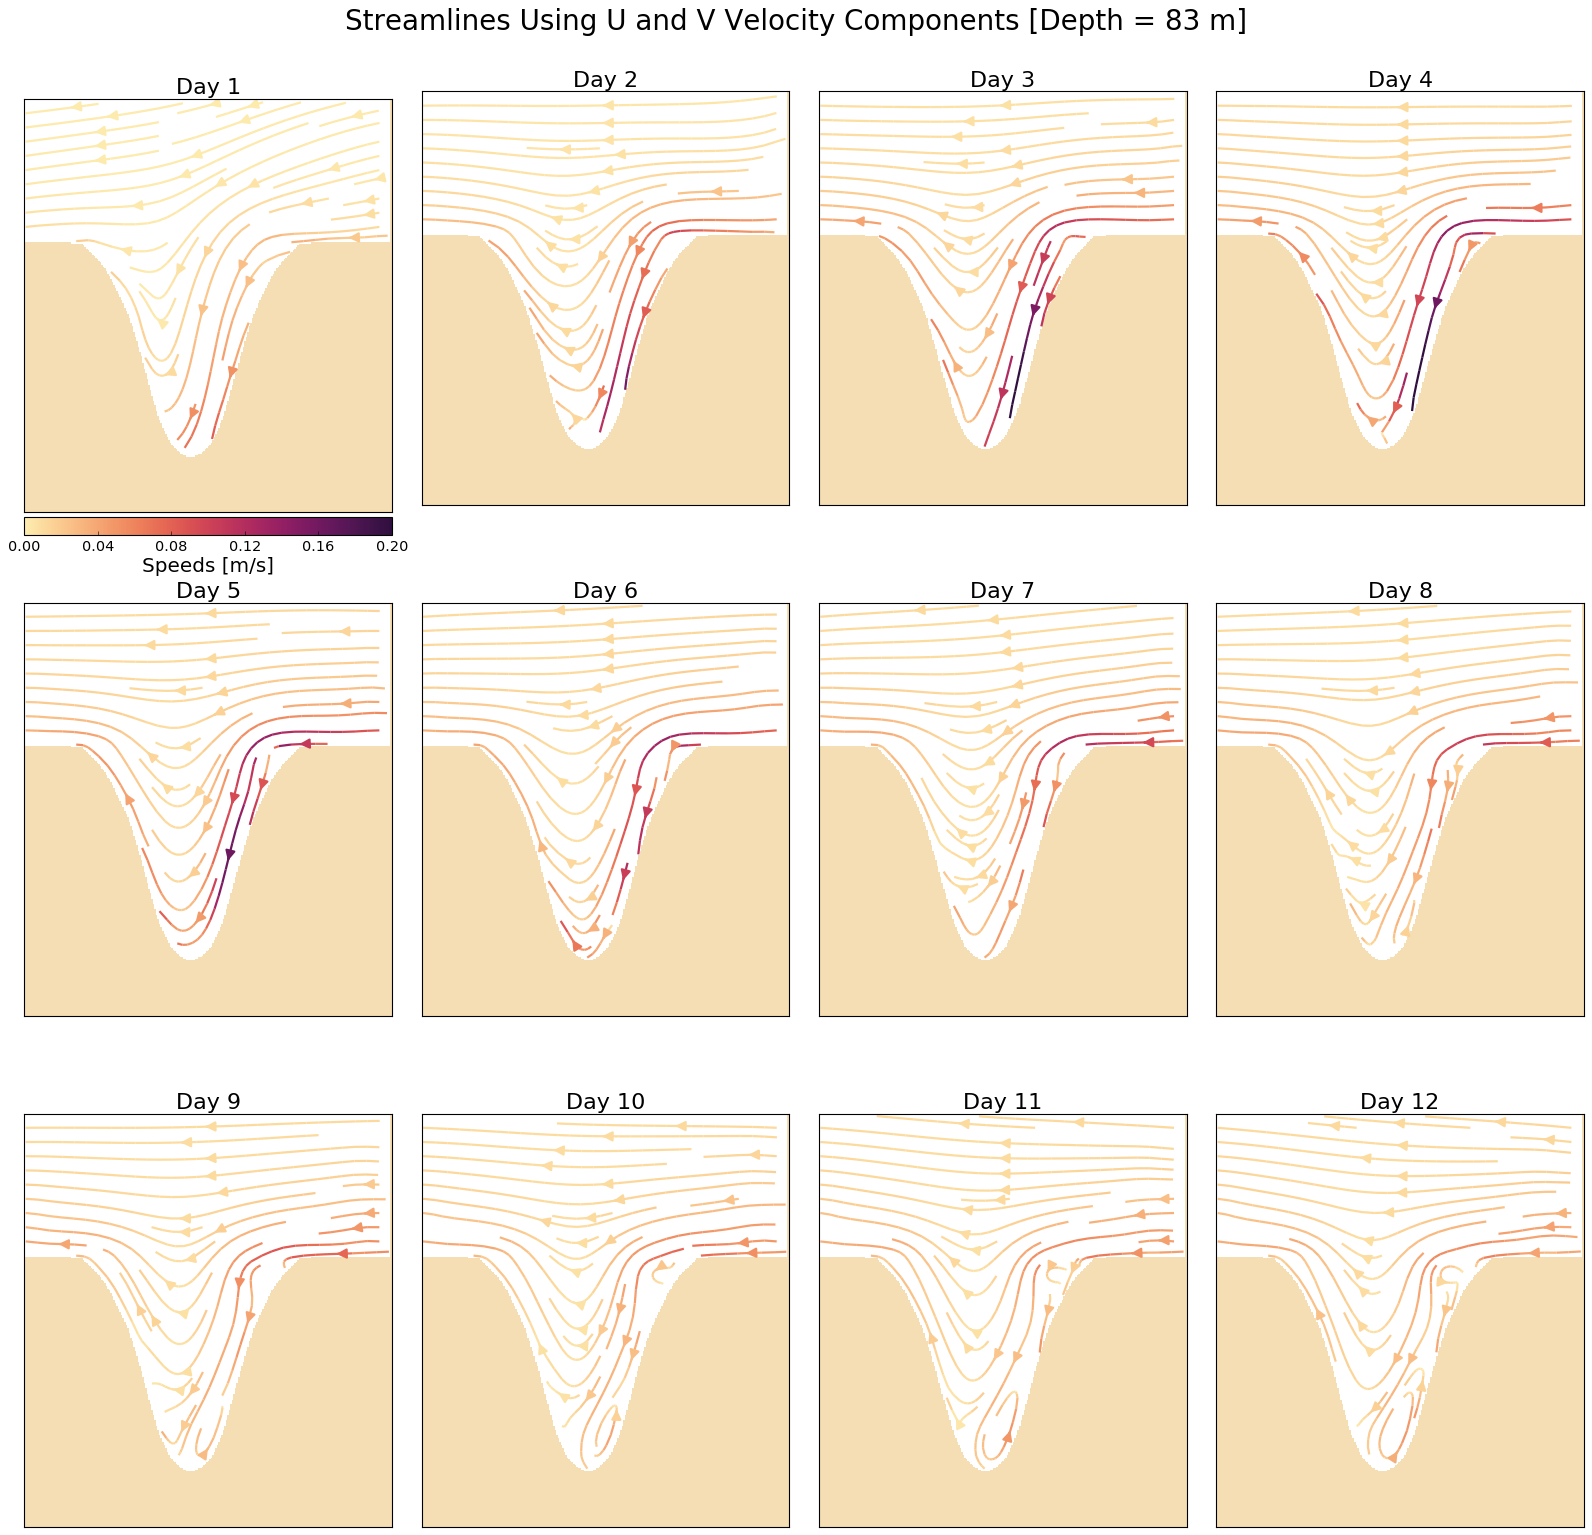

In [81]:
fig, axes = plt.subplots(3, 4, figsize = (20, 20))
for ax, n in zip(axes.flatten(), np.arange(12)):
    U_vel = get_1day_avg(vozocrtxA, n, n+1)
    V_vel = get_1day_avg(vomecrtyA, n, n+1)
    x_slice, y_slice, u_nstg, v_nstg, speeds = get_speeds(U_vel, V_vel, arrow)
    #q = ax.quiver(x_slice, y_slice, u_nstg, v_nstg, speeds, clim=[0,0.1],
    #                      pivot='mid', cmap='Blues', width=0.003, headwidth=2, headlength=8)
    ax.pcolormesh(umask[0,:,:], cmap=cmap, zorder=1)
    strm = ax.streamplot(x_slice, y_slice, u_nstg, v_nstg, 
                         color=speeds, cmap=cmo.cm.matter, density=1, linewidth=2, norm=norm, arrowsize=2, zorder=2)
    
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_aspect(aspect='equal')
    ax.set_xlim([0, umask.shape[-1]])
    ax.set_ylim([0, umask.shape[-2]])
    ax.set_title('Day ' + str(n+1), fontsize=20)
    if n == 0:
        cbar = fig.colorbar(strm.lines, ax=ax, fraction=0.05, orientation='horizontal', pad=0.009)
        cbar.set_label('Speeds [m/s]', fontsize=18, rotation=0, labelpad=2.5)
        cbar.ax.tick_params(labelsize=13)
        tick_locator = ticker.MaxNLocator(nbins=5)
        cbar.locator = tick_locator
        cbar.update_ticks()
    else:
        pass
fig.tight_layout(w_pad=1.2, h_pad=0.01)
fig.suptitle('Streamlines Using U and V Velocity Components [Depth = '+str(int(depthu[dep_ind]))+' m]', fontsize=25)
plt.subplots_adjust(top=0.95)
fig.savefig('streamlines.png', dpi=fig.dpi)